# Jobs : EDA, Data Wrangling and Feature Engineering

In [437]:
# libraries import

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

import re
import datetime
from datetime import date
from time import strptime

import RAKE as rake
import operator


# Step 1. EDA
* First removing nulls
* making dataset 'even' by- 
        --dropping row/ columns 
        --imputing values as needed
        

In [438]:
# First reading my job csv
job = pd.read_csv('naukri_com-job_sample.csv')

In [439]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              21996 non-null  object 
 1   education            20004 non-null  object 
 2   experience           21996 non-null  object 
 3   industry             21995 non-null  object 
 4   jobdescription       21996 non-null  object 
 5   jobid                22000 non-null  int64  
 6   joblocation_address  21499 non-null  object 
 7   jobtitle             22000 non-null  object 
 8   numberofpositions    4464 non-null   float64
 9   payrate              21903 non-null  object 
 10  postdate             21977 non-null  object 
 11  site_name            3987 non-null   object 
 12  skills               21472 non-null  object 
 13  uniq_id              22000 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 2.3+ MB


### As, noticed, there are null values in dataset. So very first step is to study nulls and remove or impute.

In [440]:
#removing nulls
job.drop(job.columns[[5,8, 11, 13]], axis = 1, inplace = True) 

# Step 2. Data Wrangling and Feature Engineering


I will be working on each column to understand data better. 
* remove/ impte nulls as needed
* custom feature, binning, mapping(convert text to number) as needed for each column
* if needed for vectorization in my model later, I will just keep text data as is - so it can be used for tonekization/ vectorization

#########################################################################################################
## a. Job Description

#########################################################################################################

In [441]:
#there a 4 nulls in job description

job[job['jobdescription'].isnull()]

,company,education,experience,industry,jobdescription,joblocation_address,jobtitle,payrate,postdate,skills
3768,NaN,NaN,NaN,NaN,NaN,NaN,1-50 of 680 Service Desk Jobs in Chennai,NaN,NaN,NaN
4026,NaN,NaN,NaN,NaN,NaN,NaN,1-50 of 658 .net Developer Jobs in Chennai,NaN,NaN,NaN
4389,NaN,NaN,NaN,NaN,NaN,NaN,1-50 of 574 Asp.net Jobs in Chennai,NaN,NaN,NaN
4841,NaN,NaN,NaN,NaN,NaN,NaN,1-50 of 507 Risk Analyst Jobs in Chennai,NaN,NaN,NaN


### Job description is mandatory column. So need to drop rows with nan jobdescription

In [442]:
job.drop(job[job['jobdescription'].isna()].index, axis=0, inplace=True)

In [443]:
job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 21999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company              21996 non-null  object
 1   education            20004 non-null  object
 2   experience           21996 non-null  object
 3   industry             21995 non-null  object
 4   jobdescription       21996 non-null  object
 5   joblocation_address  21499 non-null  object
 6   jobtitle             21996 non-null  object
 7   payrate              21903 non-null  object
 8   postdate             21977 non-null  object
 9   skills               21472 non-null  object
dtypes: object(10)
memory usage: 1.8+ MB


In [444]:
job.head()

,company,education,experience,industry,jobdescription,joblocation_address,jobtitle,payrate,postdate,skills
0,MM Media Pvt Ltd,UG: B.Tech/B.E. - Any Specialization PG:Any Po...,0 - 1 yrs,Media / Entertainment / Internet,Job Description Send me Jobs like this Quali...,Chennai,Walkin Data Entry Operator (night Shift),"1,50,000 - 2,25,000 P.A",2016-05-21 19:30:00 +0000,ITES
1,find live infotech,UG: B.Tech/B.E. - Any Specialization PG:MBA/PG...,0 - 0 yrs,Advertising / PR / MR / Event Management,Job Description Send me Jobs like this Quali...,Chennai,Work Based Onhome Based Part Time.,"1,50,000 - 2,50,000 P.A. 20000",2016-05-21 19:30:00 +0000,Marketing
2,Softtech Career Infosystem Pvt. Ltd,UG: Any Graduate - Any Specialization PG:Any P...,4 - 8 yrs,IT-Software / Software Services,Job Description Send me Jobs like this - as ...,Bengaluru,Pl/sql Developer - SQL,Not Disclosed by Recruiter,2016-10-13 16:20:55 +0000,IT Software - Application Programming
3,Onboard HRServices LLP,UG: Any Graduate - Any Specialization PG:CA Do...,11 - 15 yrs,Banking / Financial Services / Broking,Job Description Send me Jobs like this - Inv...,"Mumbai, Bengaluru, Kolkata, Chennai, Coimbator...",Manager/ad/partner - Indirect Tax - CA,Not Disclosed by Recruiter,2016-10-13 16:20:55 +0000,Accounts
4,Spire Technologies and Solutions Pvt. Ltd.,UG: B.Tech/B.E. - Any Specialization PG:Any Po...,6 - 8 yrs,IT-Software / Software Services,Job Description Send me Jobs like this Pleas...,Bengaluru,JAVA Technical Lead (6-8 yrs) -,Not Disclosed by Recruiter,2016-10-13 16:20:55 +0000,IT Software - Application Programming


#######################################################################################
## b. Working on years of experience  

Experience is given in the form --> 0 - 1 yrs. So I will extract the min year and accordingly put in some range. (Custom columns)
- 0-1 years -0
- 1-5 years -1
- 5-10 years-2
- 10+ years -3

#######################################################################################

In [445]:
j1=job.copy()

In [446]:
#j1['experience'] = j1.experience.str.extract('(^\d+)')
job['experience'] = job.experience.str.extract('(^\d+)')

In [447]:
job['experience']= job['experience'].astype('float')
job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 21999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              21996 non-null  object 
 1   education            20004 non-null  object 
 2   experience           21885 non-null  float64
 3   industry             21995 non-null  object 
 4   jobdescription       21996 non-null  object 
 5   joblocation_address  21499 non-null  object 
 6   jobtitle             21996 non-null  object 
 7   payrate              21903 non-null  object 
 8   postdate             21977 non-null  object 
 9   skills               21472 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.8+ MB


In [448]:
job[job['experience'].isnull()]

,company,education,experience,industry,jobdescription,joblocation_address,jobtitle,payrate,postdate,skills
1138,International Centre for Theoretical Sciences,NaN,NaN,Education / Teaching / Training,Job Description Send me Jobs like this Eligi...,Bengaluru,Postdoctoral Fellowship in Physics & Mathematics,"Salary structure is: 32,000 INR (for thesis su...",2016-10-07 16:21:25 +0000,Medical
5167,Chennai Port Trust,"Doctorate:Any Doctorate - Any Specialization, ...",NaN,Shipping / Marine,Job Description Send me Jobs like this No. o...,Chennai,Medical Officer,NaN,2015-11-26 01:33:39 +0000,Medical
7193,National Council of Educational Research and T...,"Doctorate:Any Doctorate - Any Specialization, ...",NaN,Education / Teaching / Training,Job Description Send me Jobs like this NCERT...,Delhi,Junior Project Fellow,NaN,2016-06-17 07:45:50 +0000,Teaching
7195,Indian Institute of Technology Delhi,"Doctorate:Any Doctorate - Any Specialization, ...",NaN,Education / Teaching / Training,Job Description Send me Jobs like this Adver...,Delhi,Sr. Project Scientist,"Consolidated Pay : Rs.40,000-44,000-52,000- 56...",2016-06-17 07:45:50 +0000,NaN
7206,Defence Research and Development Organisation,"Doctorate:Any Doctorate - Any Specialization, ...",NaN,Government / Defence,Job Description Send me Jobs like this Advt....,Delhi,Junior Research Fellows -IT,NaN,2016-05-05 11:34:42 +0000,IT Software - Other
...,...,...,...,...,...,...,...,...,...,...
21295,NMDC Limited,NaN,NaN,Iron and Steel,Job Description Send me Jobs like this Emplo...,Hyderabad,Asst. General Manager (Safety) (E5),Scale of Pay (Rs.) 43200-3%-66000/-,2016-12-20 18:19:23 +0000,Production
21315,Directorate of Poultry Research,NaN,NaN,Government / Defence,Job Description Send me Jobs like this Vacan...,Hyderabad,Lower Divisional Clerk,Pay Band + Grade Pay Rs. 5200-20200+Rs.1900/-,2016-12-21 18:19:24 +0000,Executive Assistant
21397,NMDC Limited,NaN,NaN,Iron and Steel,Job Description Send me Jobs like this Emplo...,Hyderabad,Asst. Manager (Safety) (E1),Scale of Pay (Rs.) 20600-3%-46500/-,2016-12-20 18:19:29 +0000,Production
21430,NMDC Limited,NaN,NaN,Iron and Steel,Job Description Send me Jobs like this Emplo...,Hyderabad,Sr. Manager (Safety) (E4),Scale of Pay (Rs.) 36600-3%-62000/-,2016-12-20 18:19:31 +0000,Production


In [449]:
job['experience'].fillna(0, inplace = True) 

In [450]:
job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 21999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              21996 non-null  object 
 1   education            20004 non-null  object 
 2   experience           21996 non-null  float64
 3   industry             21995 non-null  object 
 4   jobdescription       21996 non-null  object 
 5   joblocation_address  21499 non-null  object 
 6   jobtitle             21996 non-null  object 
 7   payrate              21903 non-null  object 
 8   postdate             21977 non-null  object 
 9   skills               21472 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.8+ MB


In [451]:
job['experience'].value_counts()

experience
2.0     4530
3.0     3497
1.0     2733
0.0     2714
5.0     2174
4.0     1995
6.0     1030
10.0     991
8.0      830
7.0      698
12.0     214
9.0      206
15.0     201
11.0      48
13.0      41
14.0      41
20.0      19
18.0      15
16.0      11
17.0       5
23.0       1
25.0       1
26.0       1
Name: count, dtype: int64

In [452]:
# converting experiences to int
job['experience'] = job['experience'].astype('int')

Text(0, 0.5, 'Number of Jobs')

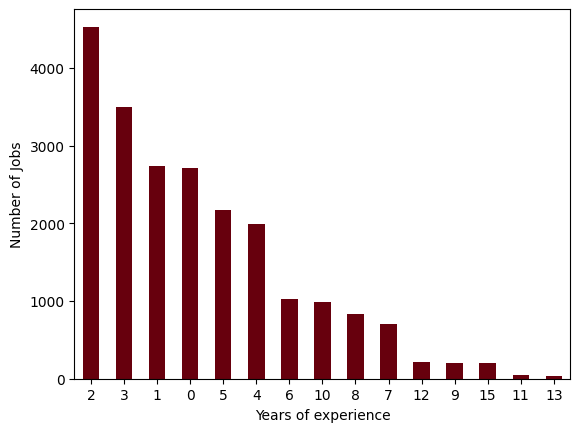

In [453]:
# plotting and analysing the experience range
job['experience'].value_counts()[:15].plot(cmap='Reds_r',kind='bar')
plt.xlabel("Years of experience")
plt.xticks(rotation=0)
plt.ylabel("Number of Jobs")

### Binning years of experience in experince range in order to match resume experience range

In [454]:
arr = np.array([0,2,6,11])
job['experience_range'] = arr.searchsorted(job.experience, side='right') - 1

In [455]:
job['experience_range'].value_counts()

experience_range
1    12196
0     5447
2     3755
3      598
Name: count, dtype: int64

Text(0, 0.5, 'Number of Jobs')

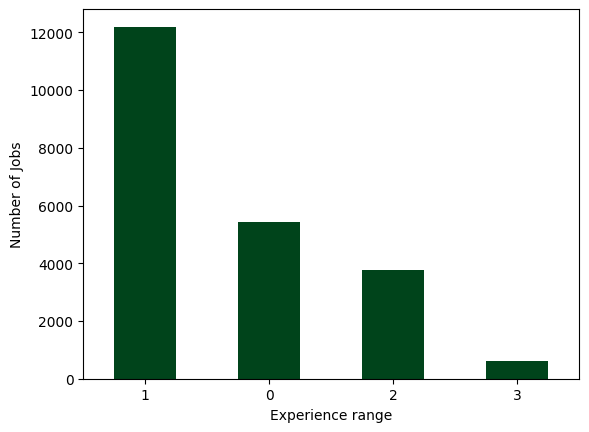

In [456]:
#plotting and glasing new range
job['experience_range'].value_counts().plot(cmap='Greens_r',kind='bar')
plt.xlabel("Experience range")
plt.xticks(rotation=0)
plt.ylabel("Number of Jobs")

#  0-1 years   -0
#  1-5 years   -1
#  5-10 years  -2
#  10+ years   -3

In [457]:
# time to time saving my data to avoid working from scratch whenever kernel dies/ restarts for whatever reason
# j_work_ex = job.copy()
# j_work_ex.to_csv('job_sorted_workex.csv', index=False)

#########################################################################
##  c. Industry
#########################################################################

In [458]:
# analysis and clean industry
job['industry'].value_counts()

industry
IT-Software / Software Services           9216
Education / Teaching / Training           1322
BPO / Call Centre / ITES                  1254
Banking / Financial Services / Broking    1238
Recruitment / Staffing                    1129
                                          ... 
Brewery / Distillery                         4
Medical Devices / Equipments                 4
Pulp and Paper                               2
Leather                                      1
Broadcasting                                 1
Name: count, Length: 63, dtype: int64

In [459]:
job['industry'].fillna('IT-Software / Software Services', inplace = True) 

In [460]:
job['industry'].nunique()

63

In [461]:
job['industry'].value_counts()

industry
IT-Software / Software Services           9217
Education / Teaching / Training           1322
BPO / Call Centre / ITES                  1254
Banking / Financial Services / Broking    1238
Recruitment / Staffing                    1129
                                          ... 
Brewery / Distillery                         4
Medical Devices / Equipments                 4
Pulp and Paper                               2
Leather                                      1
Broadcasting                                 1
Name: count, Length: 63, dtype: int64

### Generated both enumeration and OneHotEncoder for industry. 
* Initially decided to go with enumeration to match resumes
* **Decision : As I needed text for vectorization later, so kept it as is without enumeration or One-hot-encode**

In [462]:
#######job['industry_enum'] = pd.factorize(job['industry'])[0] + 1  - enumeration
#### need to OneHotEncode industry....
from sklearn.preprocessing import OneHotEncoder

s = job['industry'].str.split('/').explode()
encoder = OneHotEncoder()
encoded = encoder.fit_transform(s.values[:, None])
one_hot_df = pd.DataFrame(encoded.toarray(), columns=np.ravel(encoder.categories_), dtype='int') \
                .groupby(s.index) \
                .sum()

In [463]:
one_hot_df.head()

,,Accessories,Aerospace Firms,Air Conditioning,Airlines,Analytics,Appliances,Auto Anciliary,Auto Components,Automation,...,Security,Semiconductors,Shipping,Strategy,Telecom,Textiles,Travel,Tyres,Water Treatment,Wellness
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#########################################################################
##  d. Job Title
#########################################################################

In [464]:
job['jobtitle'] = job['jobtitle'].str.lower()

In [465]:
job['jobtitle'].nunique()

17177

In [466]:
job['jobtitle'].value_counts()

jobtitle
business development manager                             101
business development executive                            96
software engineer                                         88
android developer                                         77
php developer                                             72
                                                        ... 
tsm backup administration - gurgaon                        1
deputy manager - talent acquisition( male candidates)      1
executive - manufacturing accounts (male)                  1
sr software test engineer- soap ui/ groovy                 1
rf firmware engineers                                      1
Name: count, Length: 17177, dtype: int64

Text(0, 0.5, 'Number of Jobs')

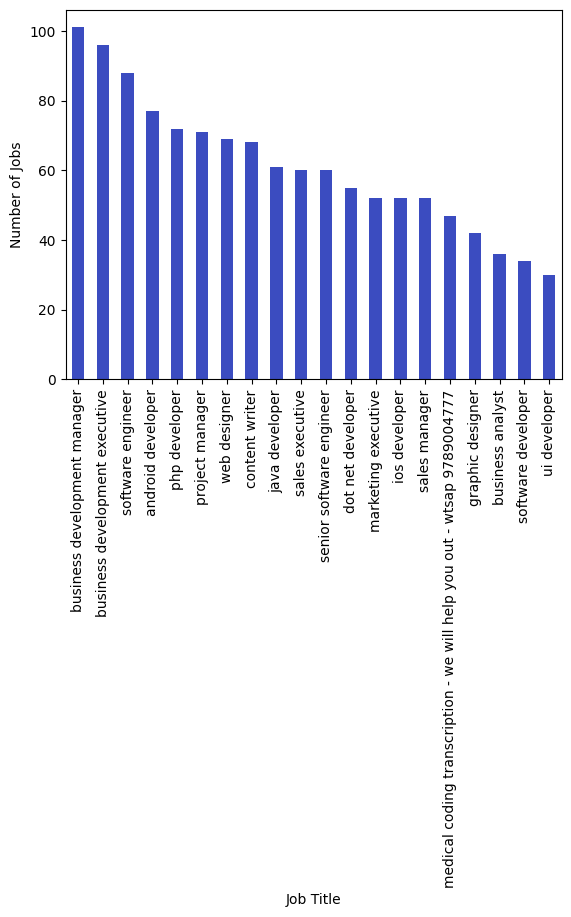

In [467]:
job['jobtitle'].value_counts().head(20).plot(cmap='coolwarm',kind='bar')
plt.xlabel("Job Title")
#plt.xticks(rotation=0)
plt.ylabel("Number of Jobs")

#########################################################################
##  e. Skills
#########################################################################

In [468]:
j1['skills'].unique() # could have enumerated but I need as is test for my model

array(['ITES', 'Marketing', 'IT Software - Application Programming',
       'Accounts', 'Production', 'Sales', 'IT Software - Other',
       'Executive Assistant', 'IT Software - Mobile',
       'Engineering Design', 'Financial Services', 'Hotels',
       'IT Software - QA & Testing', 'HR', 'Supply Chain',
       'IT Software - Network Administration', 'Architecture', 'Legal',
       'Site Engineering', 'Journalism', nan, 'IT Software - DBA',
       'Strategy', 'Medical', 'Design', 'Defence Forces',
       'IT Software - Mainframe', 'IT Software - Telecom Software',
       'IT Software - Embedded', 'IT Software - Middleware', 'Teaching',
       'IT Software - System Programming',
       'IT Software - Client/Server Programming', 'Travel',
       'IT Software - eCommerce', 'TV', 'Fashion Designing',
       'IT Software - ERP', 'IT Hardware',
       'Analytics & Business Intelligence', 'Beauty/Fitness/Spa Services',
       'Top Management', 'Export', 'IT Software - Systems', 'Packaging',

In [469]:
job.isnull().sum()

company                   0
education              1992
experience                0
industry                  0
jobdescription            0
joblocation_address     497
jobtitle                  0
payrate                  93
postdate                 19
skills                  524
experience_range          0
dtype: int64

In [470]:
job['skills'].nunique()

45

In [471]:
job['skills'].fillna('others', inplace = True) 

#########################################################################
##  f. Payrate

**in case needed, i have converted object to float  and perform Enumeration:**

- unknown = 0 
- depend on candidate/ negotiable = 1
- if given, = higher limit

#########################################################################


In [472]:
job['payrate'].unique()

array(['1,50,000 - 2,25,000 P.A', '1,50,000 - 2,50,000 P.A. 20000',
       'Not Disclosed by Recruiter', ...,
       '35,00,000 - 50,00,000 P.A. Compensation: Best in Industry',
       '15,00,000 - 30,00,000 P.A. Salary is open',
       '8,50,000 - 14,00,000 P.A'], dtype=object)

In [473]:
job['payrate'].fillna('Not Disclosed by Recruiter', inplace = True) 

In [474]:
job['payrate'].nunique()

1848

In [475]:
job['payrate']=job['payrate'].str.lower()


In [476]:
job.isnull().sum()

company                   0
education              1992
experience                0
industry                  0
jobdescription            0
joblocation_address     497
jobtitle                  0
payrate                   0
postdate                 19
skills                    0
experience_range          0
dtype: int64

In [477]:
# read each row 
# set salary = actual if given, 0 - not given, 1 - based on candidate
amt = ''
for index, rows in job.iterrows():
    #pick education col and read it as JSON 
    pay = job['payrate'][index]
    try: pay = re.sub(r'[^\w\s]','',pay)
    except: continue
    #print(pay)
    if re.search('not disclosed by recruiter', pay):
        job.loc[index,'Salary_range'] = 0
    elif re.search('^\D*\d+\D+(\d+)', pay):
        amt = re.findall('^\D*\d+\D+(\d+)', pay)
        #amt= int(float(amt))
        #print(amt[0])
        job.loc[index,'Salary_range'] = amt[0]    
    elif re.search('best|negotiable|good|no bar|not a constra|based|discuss|competitive|excellent|as per|generous', pay):
        job.loc[index,'Salary_range'] = 1
    else:
        job.loc[index,'Salary_range'] = 0

In [478]:
job['Salary_range']=job['Salary_range'].astype('float')

#########################################################################
##  g. Education

* **custom feature same as resume for better match**

#########################################################################

In [479]:
job['education'].fillna('any graduate', inplace = True) # any nulls - assuming UG is min requirement of most jobs

In [480]:
for index, rows in job.iterrows():
    #pick education col and read it as JSON 
    edu = job['education'][index]
    edu= edu.lower()
    #print(edu)
    #for ug1 in ug:       
    if re.search('^ph.d|any doctorate', edu):
        #print("Doctrate")
        job.loc[index,'is_doc'] = 1
        job.loc[index,'is_postgrad'] = 1
        job.loc[index,'is_grad'] = 1        
    elif re.search(('^m|^pg|^post '), edu):
        #print("Post-grad")
        job.loc[index,'is_doc'] = 0
        job.loc[index,'is_postgrad'] = 1
        job.loc[index,'is_grad'] = 1
    elif re.search('^b|^ug|^u.g|any graduate', edu):
        #print("Graduate")
        job.loc[index,'is_grad'] = 1
        job.loc[index,'is_postgrad'] = 0
        job.loc[index,'is_doc'] = 0

In [481]:
job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 21999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              21996 non-null  object 
 1   education            21996 non-null  object 
 2   experience           21996 non-null  int32  
 3   industry             21996 non-null  object 
 4   jobdescription       21996 non-null  object 
 5   joblocation_address  21499 non-null  object 
 6   jobtitle             21996 non-null  object 
 7   payrate              21996 non-null  object 
 8   postdate             21977 non-null  object 
 9   skills               21996 non-null  object 
 10  experience_range     21996 non-null  int64  
 11  Salary_range         21996 non-null  float64
 12  is_grad              21975 non-null  float64
 13  is_postgrad          21975 non-null  float64
 14  is_doc               21975 non-null  float64
dtypes: float64(4), int32(1), int64(1), object

In [482]:
job['is_grad'].fillna(1, inplace = True)
job['is_postgrad'].fillna(0, inplace = True)
job['is_doc'].fillna(0, inplace = True)

In [483]:
#job.to_csv('wip/sorted_job_new.csv',index=False)

In [484]:
# need to drop post date
#job.drop(job.columns[8], axis = 1, inplace = True)

#########################################################################
##  h. Job_location
### Very important feature, as at some point I might need to filter down to jobs for location matching the resume location. 

### There were multiple discrepancies observed in location column.

* Like some city, states, pincodes, nulls. I have to ensure one common format
* For any missing/ number values, I choose to make it generic with India with code 1

**So I decided to:**
* get all location
* map to respective states
* provide them uniques location code (to match with resume location). 

**Challenge** - Location code should be same in job and resume dataset to make sense and match properly. 


## Created following datasets, and use the same for both datasets (resume and job)
* **India-state-city dataset** used in jobs dataset. In resume, we are provided with States
* **State - State-id dataset**

#########################################################################

In [485]:
job['joblocation_address'].fillna('India', inplace = True) 

In [486]:
job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 21999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              21996 non-null  object 
 1   education            21996 non-null  object 
 2   experience           21996 non-null  int32  
 3   industry             21996 non-null  object 
 4   jobdescription       21996 non-null  object 
 5   joblocation_address  21996 non-null  object 
 6   jobtitle             21996 non-null  object 
 7   payrate              21996 non-null  object 
 8   postdate             21977 non-null  object 
 9   skills               21996 non-null  object 
 10  experience_range     21996 non-null  int64  
 11  Salary_range         21996 non-null  float64
 12  is_grad              21996 non-null  float64
 13  is_postgrad          21996 non-null  float64
 14  is_doc               21996 non-null  float64
dtypes: float64(4), int32(1), int64(1), object

In [487]:
#job_temp = job.copy()
#job_temp.to_csv('wip/sorted_jobs_master.csv', index=False)

In [488]:
#job = pd.read_csv('wip/sorted_jobs_master.csv')
#adding index to job table
job.reset_index(inplace=True)
job['j_id'] = job.index

In [489]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21996 entries, 0 to 21995
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                21996 non-null  int64  
 1   company              21996 non-null  object 
 2   education            21996 non-null  object 
 3   experience           21996 non-null  int32  
 4   industry             21996 non-null  object 
 5   jobdescription       21996 non-null  object 
 6   joblocation_address  21996 non-null  object 
 7   jobtitle             21996 non-null  object 
 8   payrate              21996 non-null  object 
 9   postdate             21977 non-null  object 
 10  skills               21996 non-null  object 
 11  experience_range     21996 non-null  int64  
 12  Salary_range         21996 non-null  float64
 13  is_grad              21996 non-null  float64
 14  is_postgrad          21996 non-null  float64
 15  is_doc               21996 non-null 

### Sorting joblocation_address to match Resume location

In [490]:
job['joblocation_address'].value_counts()

joblocation_address
Bengaluru/Bangalore                                                                          3775
Mumbai                                                                                       2348
Bengaluru                                                                                    1453
Hyderabad / Secunderabad                                                                     1246
Chennai                                                                                      1204
                                                                                             ... 
Delhi/NCR(National Capital Region) , Ernakulam / Kochi/ Cochin , Kanpur , Kolkata , Nasik       1
Gurgaon , Noida , Delhi                                                                         1
Pune , Noida                                                                                    1
Pune , Delhi , Bengaluru/Bangalore                                                              1


### As seen there are multiple cities listed in job location, to match with resume:

* I need to split column into multiple rows for each location
* Get state for each city to match with resume
* So, my new column 'location' should contain State or India if blank 

In [491]:
#step 1:
#spliting multiple values in joblocation_address column to 
job = job.drop('joblocation_address', axis=1).join(job['joblocation_address'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('location'))

In [492]:
# step 2: 
##getting only first word from location as we see there is Delhi NCR
job['location'] = job['location'].str.split().str[0].str.strip()
job['location'] = job['location'].str.split('/').str[0].str.strip()

#### Now, I am going to get state, city data from India 

In [493]:
state_city = pd.read_csv('india-city-state.csv') # reading city state database

In [494]:
# step 3:
##get states for each location to match resume
state_city.head()

,city_id,city_name,state
0,1,Kolhapur,Maharashtra
1,2,Port Blair,Andaman & Nicobar Islands
2,3,Adilabad,Andhra Pradesh
3,4,Adoni,Andhra Pradesh
4,5,Amadalavalasa,Andhra Pradesh


In [495]:
#job['location'] = pd.to_numeric(job.location, errors='coerce').fillna(0)
# job['location']=job['location'].replace(regex='([a-zA-Z])', value=0)
# job['location'].replace('-', 0,inplace=True)
job['location'].value_counts()

location
Bengaluru        9860
Mumbai           6118
Hyderabad        4579
Delhi            4280
Chennai          3392
                 ... 
Puri                1
Madhyapradesh       1
Wadala              1
BANDRA              1
south               1
Name: count, Length: 366, dtype: int64

In [496]:
#renaming for mapping - may not be needed but for clarity
state_city.rename(columns={'city_name': 'location'}, inplace=True)

#dropping city-id
#state_city.drop(state_city.columns[[0]], axis = 1, inplace = True) 

#creating city state dict
location_dict = pd.Series(state_city.state.values,index=state_city.location).to_dict()

In [497]:
# Finally replaced locations as states
job = job.replace({"location": location_dict}) 

In [498]:
job['location']

0         Tamil Nadu
1         Tamil Nadu
2          Karnataka
3        Maharashtra
3          Karnataka
            ...     
21992        Haryana
21993      Karnataka
21994          Delhi
21994      Karnataka
21995      Karnataka
Name: location, Length: 38941, dtype: object

In [499]:
#Adding loc id 
state = pd.read_csv('state.csv')

In [500]:
#creating city state dict
state_dict = pd.Series(state.State_id.values,index=state.State).to_dict()

In [501]:
job['location'].fillna('India', inplace = True) 

In [502]:
# Finally replaced locations as states
job = job.replace({"location": state_dict}) 

In [503]:
job['location'].isna().sum()

0

In [504]:
job['location'].value_counts()

location
16               10089
20                7432
2                 4908
9                 4280
30                3647
                 ...  
Madhyapradesh        1
NAVI                 1
Baroda               1
Alaska               1
south                1
Name: count, Length: 220, dtype: int64

In [505]:
#creating city state dict
state_dict_1 = pd.Series(state.State.values,index=state.State_id).to_dict()
job['loc_name'] = job['location'].map(state_dict_1)

In [506]:
job['loc_name'].value_counts()

loc_name
Karnataka            10089
Maharashtra           7432
Andhra Pradesh        4908
Delhi                 4280
Tamil Nadu            3647
Haryana               2157
Gujarat                619
West Bengal            554
India                  535
Punjab                 255
Uttar Pradesh          228
Rajasthan              143
Madhya Pradesh         115
Kerala                  69
Uttarakhand             50
Assam                   45
Bihar                   41
Jharkhand               38
Chhattisgarh            33
Orissa                  30
Pondicherry             15
Jammu & Kashmir         11
Himachal Pradesh        10
Goa                      4
Lakshadweep              3
Nagaland                 1
Arunachal Pradesh        1
Name: count, dtype: int64

In [507]:
job['loc_name'].isna().sum()

3628

Text(0, 0.5, 'Number of Jobs')

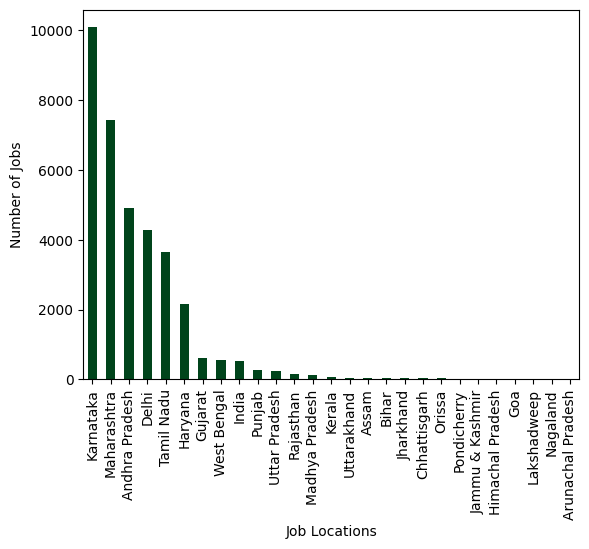

In [508]:
job['loc_name'].value_counts().plot(cmap='Greens_r',kind='bar')
plt.xlabel("Job Locations")
#plt.xticks(rotation=0)
plt.ylabel("Number of Jobs")

In [509]:
x =  job.copy()
x.to_csv('sorted_jobs_master_new2.csv', index=False)

In [510]:
job = pd.read_csv('sorted_jobs_master_new2.csv')
job.head()

,index,company,education,experience,industry,jobdescription,jobtitle,payrate,postdate,skills,experience_range,Salary_range,is_grad,is_postgrad,is_doc,j_id,location,loc_name
0,0,MM Media Pvt Ltd,UG: B.Tech/B.E. - Any Specialization PG:Any Po...,0,Media / Entertainment / Internet,Job Description Send me Jobs like this Quali...,walkin data entry operator (night shift),"1,50,000 - 2,25,000 p.a",2016-05-21 19:30:00 +0000,ITES,0,225000.0,1.0,0.0,0.0,0,30,Tamil Nadu
1,1,find live infotech,UG: B.Tech/B.E. - Any Specialization PG:MBA/PG...,0,Advertising / PR / MR / Event Management,Job Description Send me Jobs like this Quali...,work based onhome based part time.,"1,50,000 - 2,50,000 p.a. 20000",2016-05-21 19:30:00 +0000,Marketing,0,250000.0,1.0,0.0,0.0,1,30,Tamil Nadu
2,2,Softtech Career Infosystem Pvt. Ltd,UG: Any Graduate - Any Specialization PG:Any P...,4,IT-Software / Software Services,Job Description Send me Jobs like this - as ...,pl/sql developer - sql,not disclosed by recruiter,2016-10-13 16:20:55 +0000,IT Software - Application Programming,1,0.0,1.0,0.0,0.0,2,16,Karnataka
3,3,Onboard HRServices LLP,UG: Any Graduate - Any Specialization PG:CA Do...,11,Banking / Financial Services / Broking,Job Description Send me Jobs like this - Inv...,manager/ad/partner - indirect tax - ca,not disclosed by recruiter,2016-10-13 16:20:55 +0000,Accounts,3,0.0,1.0,0.0,0.0,3,20,Maharashtra
4,3,Onboard HRServices LLP,UG: Any Graduate - Any Specialization PG:CA Do...,11,Banking / Financial Services / Broking,Job Description Send me Jobs like this - Inv...,manager/ad/partner - indirect tax - ca,not disclosed by recruiter,2016-10-13 16:20:55 +0000,Accounts,3,0.0,1.0,0.0,0.0,3,16,Karnataka


In [511]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38941 entries, 0 to 38940
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             38941 non-null  int64  
 1   company           38941 non-null  object 
 2   education         38941 non-null  object 
 3   experience        38941 non-null  int64  
 4   industry          38941 non-null  object 
 5   jobdescription    38941 non-null  object 
 6   jobtitle          38941 non-null  object 
 7   payrate           38941 non-null  object 
 8   postdate          38908 non-null  object 
 9   skills            38941 non-null  object 
 10  experience_range  38941 non-null  int64  
 11  Salary_range      38941 non-null  float64
 12  is_grad           38941 non-null  float64
 13  is_postgrad       38941 non-null  float64
 14  is_doc            38941 non-null  float64
 15  j_id              38941 non-null  int64  
 16  location          38941 non-null  object